#### The nessesary packages are numpy and xarray (both can be easilly installed to your environment via 'conda install *'), and the correction package, HRHC_function. Here we also use the most popular package-matplotlib-to plot the changes of LE after correction.

#### 1st, import packages

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import HRHC_function as hrhc

#### 2nd, load the dataset, basiclly, the dataset should be at the half-hourly or hourly scale, and contain varianles of net radiation (Rn), sensible heat (H), latent heat (LE), ground heat (G), air temperature (TA), vapor pressure deficit (or Relative humidity), and quanlity control flags including Rn_QC, H_QC, LE_QC, G_QC, NEE_QC.

In [2]:
ds = xr.open_dataset('DE-Tha_hourly_2012_2013_closed_path.nc')

##### Here we can have a look at the dataset.

In [4]:
ds

<xarray.Dataset>
Dimensions:     (time: 17544)
Coordinates:
    tower_lat   float64 ...
    tower_lon   float64 ...
    site        object ...
  * time        (time) datetime64[ns] 2012-01-01 ... 2013-12-31T23:00:00
    qntl        int64 ...
    latchunk    float64 ...
    lonchunk    float64 ...
    sublat_era  float64 ...
    sublon_era  float64 ...
Data variables: (12/19)
    H_CORR      (time) float64 ...
    LE_CORR     (time) float64 ...
    TA          (time) float64 ...
    RH          (time) float64 ...
    VPD         (time) float64 ...
    LE          (time) float64 ...
    ...          ...
    WS          (time) float64 ...
    NEE_QC      (time) float64 ...
    LE_QC       (time) float64 ...
    NETRAD_QC   (time) int64 ...
    H_QC        (time) float64 ...
    G_QC        (time) float64 ...
Attributes:
    build_time:    2021-11-29 22:46
    build_script:  /Net/Groups/BGI/people/jnelson/fluxcom/fluxcom/site_cube/e...
    site:          DE-Tha
    utc_offset:    1.0
    data_source:   ICOSDrought2018
    data_policy:   CC-BY-4.0
    data_type:     eddy_covariance/ICOSDrought2018
    cite_info:     https://doi.org/10.18160/YVR0-4898\nhttps://doi.org/10.103...
    level:         L1_hourly
    agg_code:      HR
    data_purpose:  high_RH_correction

### 3rd, this step we need to convert LE (W m-2) to ET (kg m-2 s-1 / mm s-1) based on the formula from:
### - Stull, B., 1988: An Introduction to Boundary Layer Meteorology (p.641) Kluwer Academic Publishers, Dordrecht, Netherlands
### - Foken, T, 2008: Micrometeorology. Springer, Berlin, Germany.

In [5]:
ds['ET'] = hrhc.LE_to_ET(ds.LE, ds.TA, 24) # the function now is provided in our package.

### 4st, now we can have a look of the RH effect on LE measurements at the hourly scale.

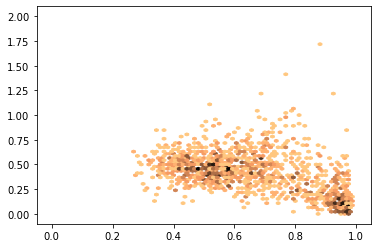

In [35]:
QC_mask = (ds['NETRAD_QC'] ==0) & (ds['H_QC'] ==0) & (ds['LE_QC'] ==0) & (ds['G_QC'] ==0) & (ds['LE'] >=0) & ((ds['NETRAD'] - ds['H'] - ds['G'])>=0) # maks sure all data are measured and without gapfilling
plt.hexbin(ds['RH'][QC_mask], (ds['LE'] / (ds['NETRAD'] - ds['H'] - ds['G']))[QC_mask], extent = [0,1,0,2],  cmap=plt.cm.copper_r, gridsize=80, mincnt=3)

### 5st, here we start to apply the high RH error correction (HRHC), as the whole correction function is a class object, so it is easilly applied by the following steps, then the correction factor, corrected ET will be added to the dataset-ds.

In [36]:
apply_hrhc = hrhc.HRHC_Correcter(ds)

In [37]:
apply_hrhc.basemask()
apply_hrhc.xgb_pred()
apply_hrhc.LE_corr()

### 6st, then we can have a look at the dateset and at the changes of LE.

In [38]:
ds

<xarray.Dataset>
Dimensions:        (time: 17544)
Coordinates:
    tower_lat      float64 50.96
    tower_lon      float64 13.57
    site           <U6 'DE-Tha'
  * time           (time) datetime64[ns] 2012-01-01 ... 2013-12-31T23:00:00
    qntl           int64 75
    latchunk       float64 51.0
    lonchunk       float64 13.0
    sublat_era     float64 0.0
    sublon_era     float64 0.5
Data variables: (12/30)
    H_CORR         (time) float64 -6.847 -5.979 -6.553 ... -31.34 -62.82 -48.01
    LE_CORR        (time) float64 0.6713 -4.908 -2.34 ... -0.04984 -0.7977
    TA             (time) float64 2.315 2.815 3.43 3.935 ... -0.525 -0.445 -0.67
    RH             (time) float64 0.958 0.9672 0.97 ... 0.785 0.7673 0.7906
    VPD            (time) float64 0.303 0.2455 0.2345 ... 1.265 1.377 1.219
    LE             (time) float64 2.872 -20.88 -9.825 ... -0.5774 -0.04 -0.6383
    ...             ...
    MEF            float64 0.09802
    LER_pred_plot  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    imb_ref        float64 0.5734
    Fcor           (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    LEcor          (time) float64 2.872 -20.88 -9.825 ... -0.5774 -0.04 -0.6383
    ETcor          (time) float64 0.004142 -0.03014 ... -5.755e-05 -0.0009182
Attributes:
    build_time:    2021-11-29 22:46
    build_script:  /Net/Groups/BGI/people/jnelson/fluxcom/fluxcom/site_cube/e...
    site:          DE-Tha
    utc_offset:    1.0
    data_source:   ICOSDrought2018
    data_policy:   CC-BY-4.0
    data_type:     eddy_covariance/ICOSDrought2018
    cite_info:     https://doi.org/10.18160/YVR0-4898\nhttps://doi.org/10.103...
    level:         L1_hourly
    agg_code:      HR
    data_purpose:  high_RH_correction

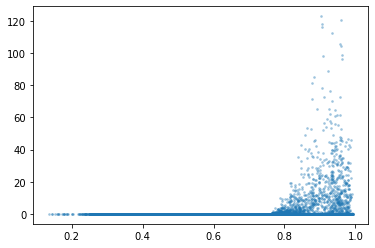

In [48]:
plt.scatter(ds.RH, ds.LEcor - ds.LE, s=3,alpha=0.3)
plt.show()